In [3]:
# jun hirabayashi jun@hirax.net

import numpy as np; import pandas as pd
import datetime as dt

# 擬似人流ファイルの読み込み
df = pd.read_csv( "2013-12-16.csv" )
df.iloc[:,2] = pd.to_datetime( df.iloc[:,2] ) # 日付・時刻
df.iloc[:,4] = df.iloc[:,4].astype(float)        # 経度：lat
df.iloc[:,3] = df.iloc[:,3].astype(float)        # 緯度：long

# 特定時間範囲の「人流情報」を抽出する
humans = df[  ( dt.datetime( 2013, 12, 16, 7, 0 ) < df.iloc[:, 2] ) & 
                      ( df.iloc[:, 2] < dt.datetime( 2013, 12, 16, 7, 1 ) ) ]

In [4]:
print( df.iloc[ 1, : ] )

1015                                            1015
unknown                                      unknown
2013-12-16 00:00:00    2013-12-16T08:35:41.000000000
35.98297679                                  35.7437
139.61399613                                 139.708
home                                             NaN
departure                                        NaN
STAY                                            MOVE
8                                                NaN
Name: 1, dtype: object


In [10]:
from ipyleaflet import *
from ipyleaflet import Map, FullScreenControl

# Jupyter ノートブックに地図表示する
m = Map( center=(35.681236,139.76712), zoom=15, 
            basemap=basemaps.OpenStreetMap.Mapnik ); m
#control = FullScreenControl(); m.add_control( control )

Map(center=[35.681236, 139.76712], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [11]:
# （地図に描画する）円マーカーを用意する
points = []
for row in humans.itertuples(name=None):
    points.append( Circle( location=(row[4], row[5]), # ( lng, lat )
        radius=150, fill=True, fill_opacity=0.3, stroke=False ) )
for point in points: # 円マーカーを描画する
    m.add_layer( point )

Box(children=(FloatSlider(value=1.0, description='opacity', max=1.0, step=0.01),))

<Figure size 7500x7500 with 0 Axes>

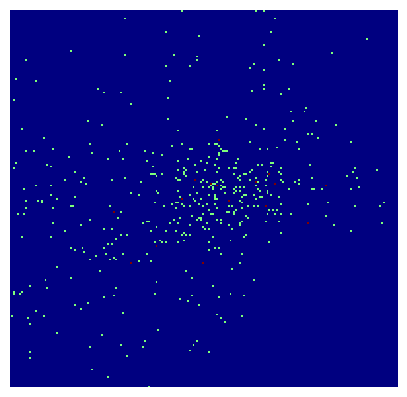

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
# 人の存在頻度を描画する、緯度経度範囲を定義
right = (2*140.4504015+138.9304186)/3
left = (140.4504015+2*138.9304186)/3
top = (2*36.3416402+35.0089399)/3
bottom = (36.3416402+2*35.0089399)/3

# 人の存在頻度を2Ｄヒストグラムとして描く
plt.figure( figsize=(15, 15), dpi=500 )
fig, ax = plt.subplots( figsize=(5, 5), dpi=100 )
ax.hist2d( humans.iloc[:,4], humans.iloc[:,3], 
           bins=[  np.linspace( left,   right, 200 ),
                      np.linspace( bottom, top,   200 )],
           cmap=plt.cm.jet )
ax.grid( False ); ax.axis('off')
# matplotlibレンダリング結果を画像(image)に格納
fig.canvas.draw()
image = np.array( fig.canvas.renderer._renderer )

#  Python 2と3で、ストリームを扱うモジュールが
# 違うため、それぞれに応じたストリーム定義にする
from base64 import b64encode; import PIL
try:
    from StringIO import StringIO
    py3 = False
except ImportError:
    from io import StringIO, BytesIO
    py3 = True
if py3:
    f = BytesIO()
else:
    f = StringIO()
# 作成した2次元画像を、地図に重ねて描画する準備
im = PIL.Image.fromarray( image ); im.save( f, 'png' )
data = b64encode( f.getvalue() )
if py3:
    data = data.decode( 'ascii' )
imgurl = 'data:image/png;base64,' + data
bounds = [ (bottom, left), (top, right) ]
io = ImageOverlay( url=imgurl, bounds=bounds )
m.add_layer( io )                            # 画像をレイヤーに追加
io.interact( opacity=( 0.0, 1.0, 0.01) ) # 透明度を可変にする


In [8]:
# 特定ユーザIDの移動過程を描画してみる
aPerson = df[ df.iloc[:, 0]==1015 ] # ユーザ抽出
locs = []; ant_paths = [] # 途中位置座標格納用の配列
for row in aPerson.itertuples( name=None ):
    locs.append( [row[4], row[5]] )  # lng, lat
# 移動過程を, AntPath（'polyline'）で描画追加する
ant_paths.append( AntPath( locations=locs, 
                             use = 'polyline') )
m += ant_paths[-1]

# m.add_layer( ant_paths )

In [11]:
# 特定時間範囲の「人流情報」のみ抽出する (クリスマス週末)
humans = df[  ( df.iloc[:, 1] == 'female' ) & 
                      (df.iloc[:, 5] != 'home' ) & (df.iloc[:, 7] == 'STAY' ) &
                      ( dt.datetime( 2013, 12, 22, 18, 0 ) < df.iloc[:, 2] ) & 
                      ( df.iloc[:, 2] < dt.datetime( 2013, 12, 22, 22, 0 ) ) ]

In [ ]:
# Clean up

In [ ]:

# 頻度分布レイヤーを消す場合
m.remove_layer( io )


In [ ]:

# 経路点レイヤーを消す場合
for point in points:
    m.remove_layer( point ); point.close()
    

In [ ]:

# アニメーション経路レイヤーを消す場合
m.remove_layer( ant_paths[-1] )
